# Finite-element mode solver

You can mesh any component cross-section and solve the PDEs thanks to [femwell](https://helgegehring.github.io/femwell/intro.html) mode - solver.

Unlike other mode solvers, this actually uses the component geometry instead of a hardcoded geometry.

You can directly compute the modes of a Gdsfactory cross-section (internally, it defines a "uz" mesh  perpendicular to a straight component with the provided cross-section).

You can also downsample layers from the LayerStack, and modify both the cross-section and LayerStack  prior to simulation to change the geometry. You can also define refractive indices on the active PDK.

In [1]:
import matplotlib.pyplot as plt
import gdsfactory as gf
from tqdm.auto import tqdm
import numpy as np
from femwell import mode_solver
from gdsfactory.simulation.fem.mode_solver import compute_cross_section_modes
from gdsfactory.technology import LayerStack
from gdsfactory.cross_section import rib
from gdsfactory.generic_tech import LAYER_STACK

import sys
import logging
from rich.logging import RichHandler
import gdsfactory as gf
from gdsfactory.generic_tech import get_generic_pdk

gf.config.rich_output()
PDK = get_generic_pdk()
PDK.activate()

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

2023-02-20 17:53:07.002 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.43.1


2023-02-20 17:53:08.260 | INFO     | gdsfactory.technology.layer_views:__init__:785 - Importing LayerViews from YAML file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/layer_views.yaml.


2023-02-20 17:53:08.267 | INFO     | gdsfactory.pdk:activate:206 - 'generic' PDK is now active


In [2]:
filtered_layerstack = LayerStack(
    layers={
        k: LAYER_STACK.layers[k]
        for k in (
            "core",
            "clad",
            "slab90",
            "box",
        )
    }
)

filtered_layerstack.layers[
    "core"
].thickness = 0.161  # Perturb the layerstack before simulating

filtered_layerstack.layers[
    "slab90"
].thickness = 0.55  # Perturb the layerstack before simulating

resolutions = {}
resolutions["core"] = {"resolution": 0.02, "distance": 2}
resolutions["clad"] = {"resolution": 0.2, "distance": 1}
resolutions["box"] = {"resolution": 0.2, "distance": 1}
resolutions["slab90"] = {"resolution": 0.05, "distance": 1}

lams, basis, xs = compute_cross_section_modes(
    cross_section=rib(width=0.6),
    layerstack=filtered_layerstack,
    wavelength=1.55,
    num_modes=4,
    resolutions=resolutions,
)

[17:53:10] INFO     INFO:rich:Using client version: 1.8.4                                           ]8;id=318103;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=390227;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py#120\120]8;;\

2023-02-20 17:53:10.318 | INFO     | gdsfactory.simulation.gtidy3d:<module>:54 - Tidy3d '1.8.4' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d']


2023-02-20 17:53:20.552 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_ec84fb00_a67759bd.npz')


The solver returns the effective indices (lams), FEM basis functions (basis) and eigenvectors (xs):

In [3]:
lams, basis, xs

(
    array([3.29578315+3.95759352e-10j, 3.28939564+2.53584628e-11j,
       3.27906765+7.14671267e-10j, 3.26428387-1.66501111e-09j]),
    <skfem CellBasis(MeshTri1, ElementComposite) object>
  Number of elements: 16044
  Number of DOFs: 32255
  Size: 73930752 B,
    array([[ 1.23333499e-02-2.37403103e-02j,  2.01378937e-02-3.87632004e-02j,
         2.44243854e-02-4.70142307e-02j, ...,
         1.70411472e-10+2.17038514e-12j,  1.89787839e-06+9.85956904e-07j,
        -1.15565799e-06-6.00378400e-07j],
       [ 2.27951906e-01-3.41630606e-02j,  4.32040250e-01-6.47497255e-02j,
         5.83742986e-01-8.74853784e-02j, ...,
         1.13119749e-10+1.09701783e-10j,  4.08988232e-07+2.72898615e-06j,
        -2.61021938e-07-1.74162880e-06j],
       [ 7.70417331e-02+1.45411136e-01j,  1.36877709e-01+2.58347596e-01j,
         1.74440969e-01+3.29245779e-01j, ...,
         1.25227234e-09-1.90422992e-10j,  1.25939074e-06-6.67100600e-07j,
        -9.51996695e-07+5.04126029e-07j],
       [ 1.06922830e-01-3.85569037e-01j,  2.05487674e-01-7.40998116e-01j,
         2.81250078e-01-1.01420051e+00j, ...,
         4.93597374e-11+1.27406651e-10j,  9.28000614e-07+2.57533357e-07j,
        -3.21851068e-07-8.93817135e-08j]])
)

You can use them as inputs to other [femwell mode solver functions](https://github.com/HelgeGehring/femwell/blob/main/femwell/mode_solver.py) to inspect or analyze the modes:

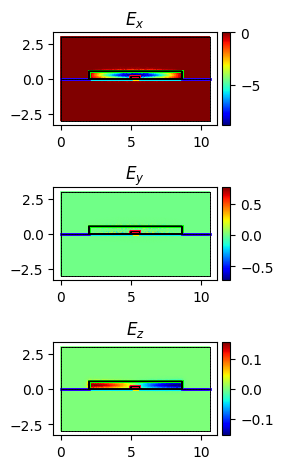

In [4]:
fig = mode_solver.plot_mode(
    basis, np.real(xs[0]), plot_vectors=False, colorbar=True, title="E", direction="y"
)

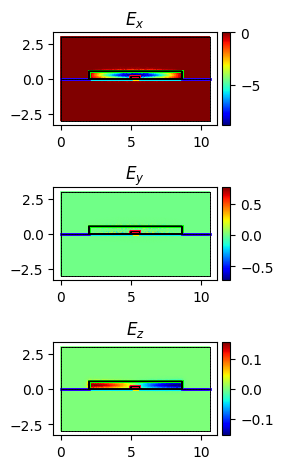

In [5]:
fig[0]

In [6]:
te_frac = mode_solver.calculate_te_frac(basis, xs[0])
te_frac

0.9994521479732367

## Sweep waveguide width

In [7]:
widths = np.linspace(0.2, 2, 20)
num_modes = 4
all_lams = np.zeros((widths.shape[0], num_modes))
all_te_fracs = np.zeros((widths.shape[0], num_modes))

for i, width in enumerate(tqdm(widths)):
    lams, basis, xs = compute_cross_section_modes(
        cross_section=gf.cross_section.strip(width=width),
        layerstack=filtered_layerstack,
        wavelength=1.55,
        num_modes=num_modes,
        resolutions=resolutions,
        wafer_padding=2,
    )
    all_lams[i] = lams
    all_te_fracs[i, :] = [
        mode_solver.calculate_te_frac(basis, xs[idx]) for idx in range(num_modes)
    ]

  0%|          | 0/20 [00:00<?, ?it/s]

2023-02-20 17:53:27.548 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_a820b8df_3a4162ac.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:53:31.913 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_9c4caf64_8acad2d0.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:53:36.148 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_9e0af5c9_58f735f6.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:53:41.773 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_71d89da5_46392ffd.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:53:46.770 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_b49bc07b_f723615c.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:53:52.536 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_c88829f5_bb138671.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:53:58.601 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_fa40ce69_d14a73bc.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:03.750 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_8d03e0f1_a29816d9.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:07.438 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_1651b90e_bcb33650.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:11.257 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_23b2062e_cf69726f.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:14.996 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_634dfeed_0689652f.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:19.123 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_47a47488_7be5ed29.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:23.549 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_1a25b7c9_ebfb7cc4.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:28.756 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_179fa6b7_5d9097ee.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:33.498 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_43363074_ca6508ee.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:38.403 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_b5beed40_ba2a403c.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:43.565 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_945aecf7_16d955d5.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:49.019 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_9ef97b27_f1f136a7.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:54:54.758 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_6533d1d2_1a8922b7.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-02-20 17:55:00.446 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_component_slice_modes:205 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/straight_1c7718c1_791777d1.npz')


/tmp/ipykernel_10184/3803157409.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


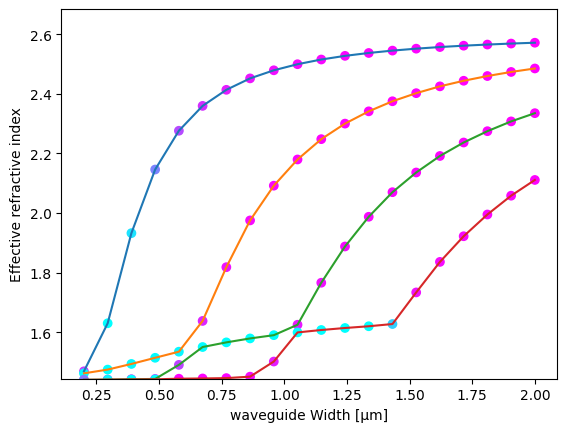

In [8]:
all_lams = np.real(all_lams)
plt.xlabel("waveguide Width [µm]")
plt.ylabel("Effective refractive index")
plt.ylim(1.444, np.max(all_lams) + 0.1 * (np.max(all_lams) - 1.444))

for lams, te_fracs in zip(all_lams.T, all_te_fracs.T):
    plt.plot(widths, lams)
    plt.scatter(widths, lams, c=te_fracs, cmap="cool")